## Chest Disease Classification 

The goal is to automate the process of detection and classification chest disease and reduce the cost and time of detection. 

---

# TASK #2: IMPORT LIBRARIES AND DATASET

In [1]:
# Import libraries 

import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Import dataset

# Specify training data directory
XRay_Directory = '/Users/mareksturek/Desktop/ChestDiseases/Dataset'

# List the folders in the directory
os.listdir(XRay_Directory)

['0', '1', '3', '2']

In [3]:
# Image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  

image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [4]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")

Found 428 images belonging to 4 classes.


In [5]:
# Validation 

validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")

Found 104 images belonging to 4 classes.


In [6]:
# Generate a batch of 40 images and labels

train_images, train_labels = next(train_generator)

In [7]:
# Train shape

train_images.shape

(40, 256, 256, 3)

In [8]:
# Train labes

train_labels.shape

(40, 4)

In [9]:
# Labels translator 

label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

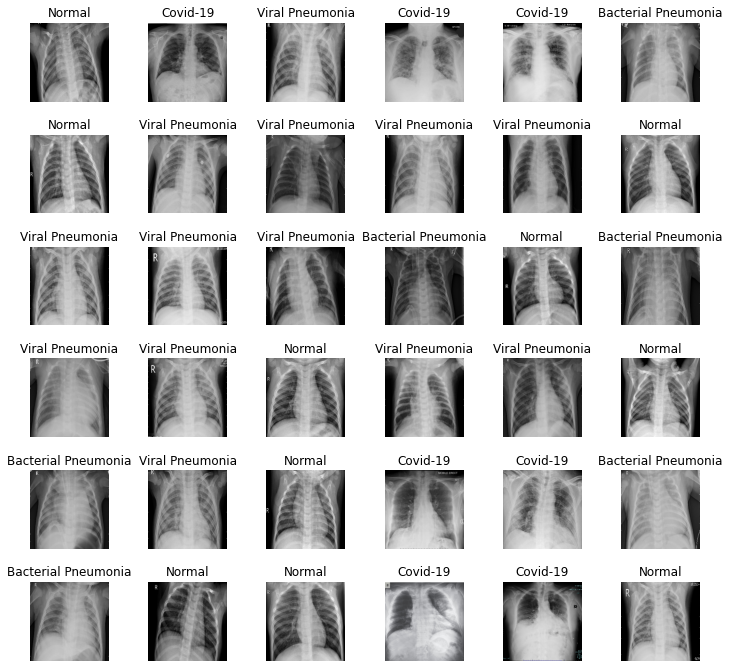

In [10]:
# Dataset visualizaton 

# Create a grid of 36 images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

In [11]:
# Import the ResNet50 model with pretrained weights 

basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [12]:
# Freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

In [13]:
# Build the deep learning model 

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [14]:
# Compile the model 

model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])

In [15]:
# Early stopping to exit training if validation loss is not decreasing even after certain epochs
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [16]:
# Generators for training and validation 

train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [17]:
# Train the model 

# history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 1, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])
history = model.fit_generator(train_generator, epochs = 5, validation_data= val_generator, callbacks=[checkpointer, earlystopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
107/107 [==============================] - ETA: 0s - loss: 0.8682 - accuracy: 0.6822
Epoch 00001: val_loss improved from inf to 7.85700, saving model to weights.hdf5
107/107 [==============================] - 284s 3s/step - loss: 0.8682 - accuracy: 0.6822 - val_loss: 7.8570 - val_accuracy: 0.2500
Epoch 2/5
107/107 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.8621
Epoch 00002: val_loss did not improve from 7.85700
107/107 [==============================] - 279s 3s/step - loss: 0.3802 - accuracy: 0.8621 - val_loss: 16.0099 - val_accuracy: 0.2500
Epoch 3/5
107/107 [==============================] - ETA: 0s - loss: 0.3440 - accuracy: 0.9019
Epoch 00003: val_loss did not improve from 7.85700
107/107 [==============================] - 271s 3s/step - loss: 0.3440 - accuracy: 0.9019 - val_loss: 72.8239 - val_accuracy: 0.2500
Epoch 4/5
107/107 [==============================] - ETA: 

In [18]:
# Labels restored in history 

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

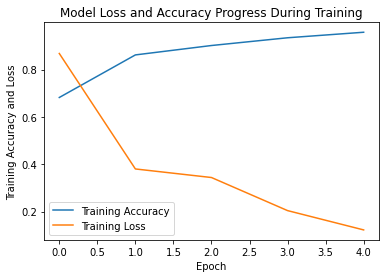

In [19]:
# Plot loss and accuracy progress during training 

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

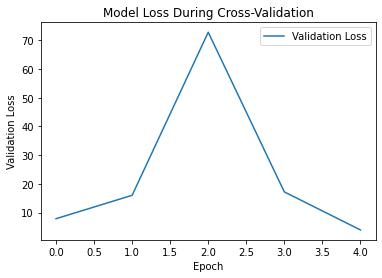

In [20]:
# Validation loss plot

plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

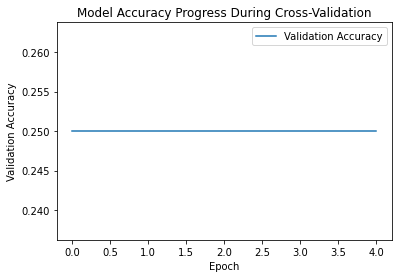

In [21]:
# Plot validation accuracy

plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [22]:
# Test directory

test_directory = '/Users/mareksturek/Desktop/ChestDiseases/Test'

In [31]:
# Test generator for unseen imagines 

test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 4, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

Found 40 images belonging to 4 classes.


In [32]:
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

10/10 [==============================] - 4s 421ms/step - loss: 4.5668 - accuracy: 0.2500
Accuracy Test : 0.25


In [49]:
# Confusion matrix, classificaiton report, accuracy

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

'''
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
      for item in os.listdir(os.path.join(test_directory,str(i))):
        img = cv2.imread(os.path.join(test_directory,str(i),item))
        img = cv2.resize(img,(256,256))
        image.append(img)
        img = img / 255
        img = img.reshape(-1,256,256,3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)
'''

'\nprediction = []\noriginal = []\nimage = []\n\nfor i in range(len(os.listdir(test_directory))):\n      for item in os.listdir(os.path.join(test_directory,str(i))):\n        img = cv2.imread(os.path.join(test_directory,str(i),item))\n        img = cv2.resize(img,(256,256))\n        image.append(img)\n        img = img / 255\n        img = img.reshape(-1,256,256,3)\n        predict = model.predict(img)\n        predict = np.argmax(predict)\n        prediction.append(predict)\n        original.append(i)\n'

In [50]:
# Original length 

len(original)

40

In [51]:
# Test accuaracy

score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.25


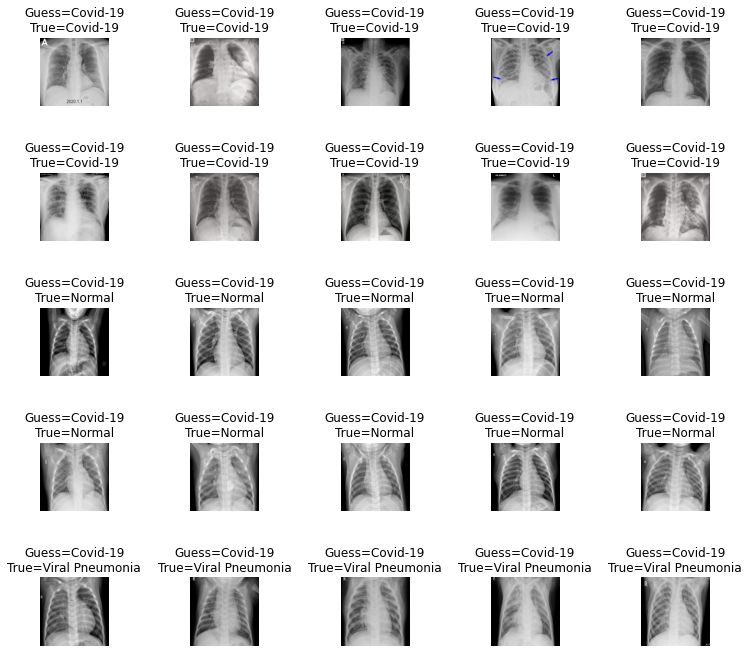

In [44]:
# Plot of tested imagines 

L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [45]:
# Classification report

print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.25      1.00      0.40        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10

    accuracy                           0.25        40
   macro avg       0.06      0.25      0.10        40
weighted avg       0.06      0.25      0.10        40



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion_matrix')

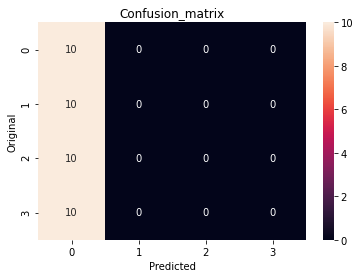

In [46]:
# Confustion matrix 

cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')